In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.integrate import odeint

In [2]:
R = 5
vol = 0.1*0.1*1
rho = 2.5
om = 10*2*np.pi/60
df = pd.read_csv('v.dat',header=None,sep='\s')
df.columns = ['ch','x','z','nc','m','vx','vy','vz','cx','cy','cz','cxz','sx','sy','sz','sxz']

<ipython-input-2-1baf139c6898>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('v.dat',header=None,sep='\s')


In [3]:
df['tx'] = (-df['cx'] + df['sx'] -df['m']*df['vx']*df['vx'])*df['nc']/vol
df['ty'] = (-df['cy'] + df['sy'] -df['m']*df['vy']*df['vy'])*df['nc']/vol
df['tz'] = (-df['cz'] + df['sz'] -df['m']*df['vz']*df['vz'])*df['nc']/vol
df['txz'] = (-df['cxz'] + df['sxz'] -df['m']*df['vx']*df['vz'])*df['nc']/vol
df['phi'] = df['nc']*df['m']/(rho*vol)
df['r'] = np.sqrt(df['x']*df['x'] + df['z']*df['z'])
df['omega'] = (-df['vx']*df['z'] + df['vz']*df['x'])/(df['r']**2)
df['theta'] = np.arctan(df['z']/df['x'])
for i in range(len(df)):
    if (df.loc[i,'x']<0) & (df.loc[i,'z']<0):
        df.loc[i,'theta']-=np.pi
df['theta']*=180/np.pi
df

,ch,x,z,nc,m,vx,vy,vz,cx,cy,...,sz,sxz,tx,ty,tz,txz,phi,r,omega,theta
0,1,-4.95,-4.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.000357,0.0,-135.000000
1,2,-4.95,-4.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.930007,0.0,-135.584631
2,3,-4.95,-4.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.860394,0.0,-136.181189
3,4,-4.95,-4.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.791539,0.0,-136.789911
4,5,-4.95,-4.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.723466,0.0,-137.411030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,4.95,4.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.723466,0.0,42.588970
9996,9997,4.95,4.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.791539,0.0,43.210089
9997,9998,4.95,4.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.860394,0.0,43.818811
9998,9999,4.95,4.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.930007,0.0,44.415369


In [4]:
zmin_dict={}
for x in np.arange(-4.95,5.00,0.05):
    df1 = df[df['x']==np.round(x,2)]
    df1.reset_index(inplace=True)
    for i in range(len(df1)-1):
        if (df1.loc[i,'vx']<0) & (df1.loc[i+1,'vx']>0):
            zmin = df1.loc[i,'z'] - 0.1*df1.loc[i,'vx']/(df1.loc[i+1,'vx']-df1.loc[i,'vx'])
            zmin_dict[x]=zmin

for i in range(len(df)):
    for x in zmin_dict.keys():
        if df.loc[i,'x'] == np.round(x,2):
            df.loc[i,'zmin'] = zmin_dict[x]

In [5]:
zmax_dict={}
for x in np.arange(-4.95,5.00,0.05):
    df1 = df[df['x']==np.round(x,2)]
    df1.reset_index(inplace=True)
    for i in range(len(df1)-1):
        if (df1.loc[i,'phi']>0.4) & (df1.loc[i+1,'phi']<0.4):
            zmax = df1.loc[i,'z'] + 0.1*(0.4-df1.loc[i,'phi'])/(df1.loc[i+1,'phi']-df1.loc[i,'phi'])
            zmax_dict[x]=zmax

for i in range(len(df)):
    for x in zmax_dict.keys():
        if df.loc[i,'x'] == np.round(x,2):
            df.loc[i,'zmax'] = zmax_dict[x]

In [6]:
df.drop(['ch'],axis=1,inplace=True)
df.to_csv('avv.dat',index=None,header=False,sep=' ')

In [7]:
intf = df[['x','zmin','zmax']]
intf.drop_duplicates(inplace=True)
intf.to_csv('intf.dat',index=None,header=False,sep=' ')

<ipython-input-7-b8a6e8e27874>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intf.drop_duplicates(inplace=True)


In [8]:
df.drop(['nc','m','cx','cy','cz','cxz','sx','sy','sz','sxz','tx','ty','tz','txz'],axis=1,inplace=True)
df

,x,z,vx,vy,vz,phi,r,omega,theta,zmin,zmax
0,-4.95,-4.95,0.0,0.0,0.0,0.0,7.000357,0.0,-135.000000,NaN,NaN
1,-4.95,-4.85,0.0,0.0,0.0,0.0,6.930007,0.0,-135.584631,NaN,NaN
2,-4.95,-4.75,0.0,0.0,0.0,0.0,6.860394,0.0,-136.181189,NaN,NaN
3,-4.95,-4.65,0.0,0.0,0.0,0.0,6.791539,0.0,-136.789911,NaN,NaN
4,-4.95,-4.55,0.0,0.0,0.0,0.0,6.723466,0.0,-137.411030,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9995,4.95,4.55,0.0,0.0,0.0,0.0,6.723466,0.0,42.588970,NaN,NaN
9996,4.95,4.65,0.0,0.0,0.0,0.0,6.791539,0.0,43.210089,NaN,NaN
9997,4.95,4.75,0.0,0.0,0.0,0.0,6.860394,0.0,43.818811,NaN,NaN
9998,4.95,4.85,0.0,0.0,0.0,0.0,6.930007,0.0,44.415369,NaN,NaN


In [9]:
df.dropna(inplace=True)
df

,x,z,vx,vy,vz,phi,r,omega,theta,zmin,zmax
100,-4.85,-4.95,0.0,0.0,0.0,0.0,6.930007,0.0,-134.415369,-0.623070,-0.485434
101,-4.85,-4.85,0.0,0.0,0.0,0.0,6.858936,0.0,-135.000000,-0.623070,-0.485434
102,-4.85,-4.75,0.0,0.0,0.0,0.0,6.788593,0.0,-135.596809,-0.623070,-0.485434
103,-4.85,-4.65,0.0,0.0,0.0,0.0,6.719003,0.0,-136.206049,-0.623070,-0.485434
104,-4.85,-4.55,0.0,0.0,0.0,0.0,6.650188,0.0,-136.827968,-0.623070,-0.485434
...,...,...,...,...,...,...,...,...,...,...,...
9795,4.75,4.55,0.0,0.0,0.0,0.0,6.577614,0.0,43.768023,-0.491112,-0.318949
9796,4.75,4.65,0.0,0.0,0.0,0.0,6.647180,0.0,44.390493,-0.491112,-0.318949
9797,4.75,4.75,0.0,0.0,0.0,0.0,6.717514,0.0,45.000000,-0.491112,-0.318949
9798,4.75,4.85,0.0,0.0,0.0,0.0,6.788593,0.0,45.596809,-0.491112,-0.318949


R2= 0.9416239831320119


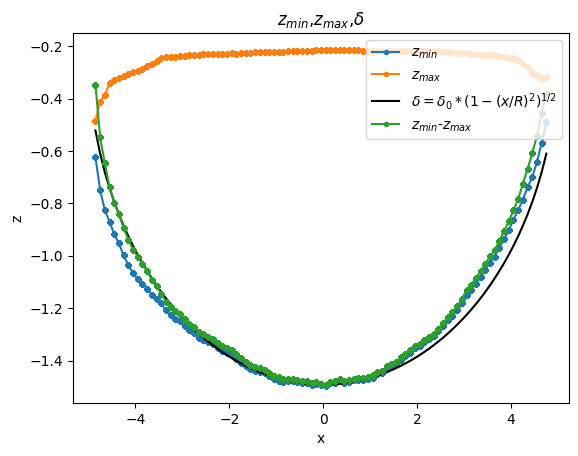

In [10]:
plt.plot(df['x'],df['zmin'],label='$z_{min}$',marker='.')
plt.plot(df['x'],df['zmax'],label='$z_{max}$',marker='.')
delta = np.min(df['zmin']-df['zmax'])*np.sqrt(1-(df['x']**2)/25)
plt.plot(df['x'],delta-0.21,label=r'$\delta = \delta_{0}*(1-(x/R)^2)^{1/2}$',c='black')
plt.plot(df['x'],df['zmin']-df['zmax']-0.21,label='$z_{min}$-$z_{max}$',marker='.')
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('z')
plt.title('$z_{min}$,$z_{max}$,$\delta$')
print('R2=',r2_score(df['zmin']-df['zmax']-0.21,delta-0.21))

### Angular velocity analysis and curve fitting

In [11]:
df = df[df['r']<=5]
theta_range = 30
df1 = df.loc[(df['theta']>-90-theta_range) & (df['theta']<-90+theta_range)]
df1['theta']+=90
df1 = df1[df1['z']-df1['zmin']<0]
df1

<ipython-input-11-bb92379e8d0f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['theta']+=90


,x,z,vx,vy,vz,phi,r,omega,theta,zmin,zmax
2506,-2.45,-4.35,0.000000,0.000000,0.000000,0.000000e+00,4.992494,0.000000,-29.389011,-1.330678,-0.231274
2507,-2.45,-4.25,-4.419540,0.005461,2.544860,5.492035e-01,4.905609,-1.039599,-29.962184,-1.330678,-0.231274
2606,-2.35,-4.35,-4.502480,0.003449,2.413830,2.007975e-01,4.944189,-1.033270,-28.379243,-1.337519,-0.231408
2607,-2.35,-4.25,-4.436510,0.001701,2.448160,6.246738e-01,4.856439,-1.043390,-28.940013,-1.337519,-0.231408
2608,-2.35,-4.15,-4.317780,0.000981,2.444670,6.115659e-01,4.769172,-1.040394,-29.521362,-1.337519,-0.231408
...,...,...,...,...,...,...,...,...,...,...,...
7306,2.35,-4.35,-0.018922,0.000005,-0.010136,6.194948e-07,4.944189,-0.004341,28.379243,-1.305838,-0.216968
7307,2.35,-4.25,-4.455510,-0.000054,-2.466160,5.823839e-01,4.856439,-1.048607,28.940013,-1.305838,-0.216968
7308,2.35,-4.15,-4.352450,0.000002,-2.467050,5.991896e-01,4.769172,-1.049032,29.521362,-1.305838,-0.216968
7406,2.45,-4.35,0.000000,0.000000,0.000000,0.000000e+00,4.992494,0.000000,29.389011,-1.286676,-0.218795


Text(0.5, 1.0, '$\\omega$ vs r for -30<theta<30')

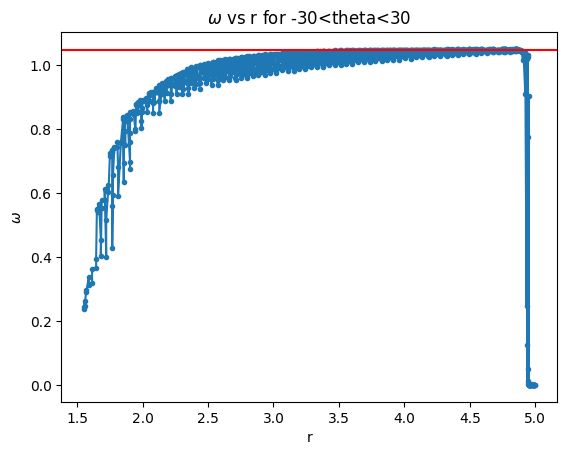

In [12]:
df2 = df1.sort_values(by='r')
df2 = df2[df2['z']-df2['zmin']<=0]
plt.plot(df2['r'],np.abs(df2['omega']),marker='.')
plt.axhline(y=om,c='red')
plt.xlabel('r')
plt.ylabel('$\omega$')
plt.title(f'$\omega$ vs r for -{theta_range}<theta<{theta_range}')

R2 =  0.9506614166064431
1.035 116.837 3.235


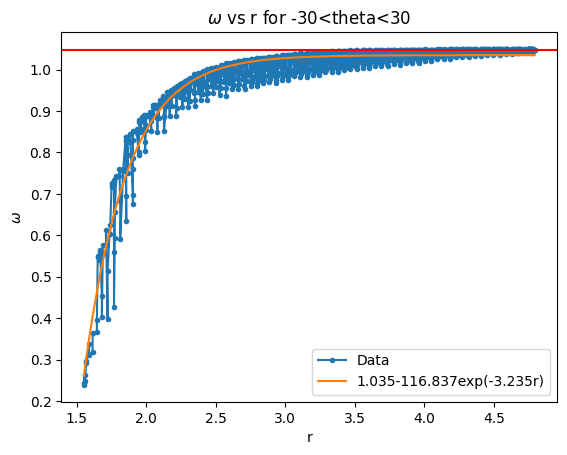

In [13]:
def fun(r,a,b,c):
    return a - b*np.exp(-c*r)

df3 = df2.loc[df2['r']<4.8]
parameters, covariance = curve_fit(fun, df3['r'], np.abs(df3['omega']),maxfev=1000)

fit_a,fit_b,fit_c=np.round(parameters,3)
y = fun(df3['r'],fit_a,fit_b,fit_c)
plt.plot(df3['r'],np.abs(df3['omega']),marker='.')
plt.plot(df3['r'],y)
plt.xlabel('r')
plt.ylabel('$\omega$')
print('R2 = ', r2_score(np.abs(df3['omega']),y))
print(fit_a,fit_b,fit_c)
plt.title(f'$\omega$ vs r for -{theta_range}<theta<{theta_range}')
plt.legend(['Data',f'{fit_a}-{fit_b}exp(-{fit_c}r)'])
plt.axhline(y=om,c='red')

<ipython-input-14-3808043335cc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['rchunk'] = np.floor(df3['r']/delta)+1


R2 =  0.9954616275265968


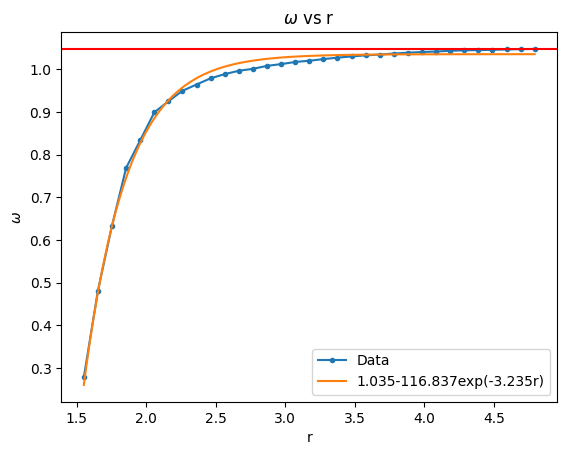

In [14]:
delta = 0.1
df3['rchunk'] = np.floor(df3['r']/delta)+1
chunked_omega = np.asarray(df3.groupby('rchunk')['omega'].mean())
# plt.plot(np.arange(1.5,4.8,0.1), np.abs(np.asarray(chunked_omega)),marker='.')
plt.plot(np.linspace(np.min(df3['r']),np.max(df3['r']),np.shape(chunked_omega)[0]), np.abs(chunked_omega),marker='.')
plt.plot(df3['r'],y)
plt.ylabel('$\omega$')
plt.xlabel('r')
plt.title(r'$\omega$ vs r')
plt.legend(['Data',f'{fit_a}-{fit_b}exp(-{fit_c}r)'])
plt.axhline(y=om,c='red')
print('R2 = ', r2_score(np.abs(chunked_omega),fun(np.linspace(np.min(df3['r']),np.max(df3['r']),np.shape(chunked_omega)[0]),fit_a,fit_b,fit_c)))

R2 =  0.9587491978778566
0.958 0.02 323.942 3.895


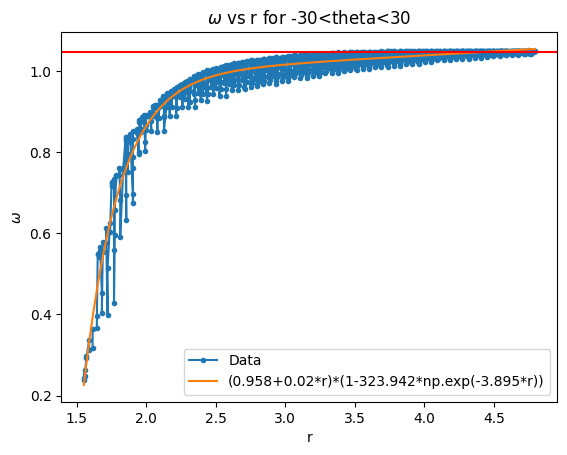

In [15]:
def fun2(r,c1,c2,c3,c4):
    return (c1+c2*r)*(1-c3*np.exp(-c4*r))

df3 = df2.loc[df2['r']<4.8]
parameters, covariance = curve_fit(fun2, df3['r'], np.abs(df3['omega']),p0=[1,0.5,100,3])

fit_c1,fit_c2,fit_c3, fit_c4 = np.round(parameters,3)
y = fun2(df3['r'],fit_c1,fit_c2,fit_c3, fit_c4)
plt.plot(df3['r'],np.abs(df3['omega']),marker='.')
plt.plot(df3['r'],y)
plt.xlabel('r')
plt.ylabel('$\omega$')
print('R2 = ', r2_score(np.abs(df3['omega']),y))
print(fit_c1,fit_c2,fit_c3, fit_c4)
plt.title(f'$\omega$ vs r for -{theta_range}<theta<{theta_range}')
plt.legend(['Data',f'({fit_c1}+{fit_c2}*r)*(1-{fit_c3}*np.exp(-{fit_c4}*r))'])
plt.axhline(y=om,c='red')

<ipython-input-16-c826d975f13a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['rchunk'] = np.floor(df3['r']/delta)+1


R2 =  0.9964383939216368


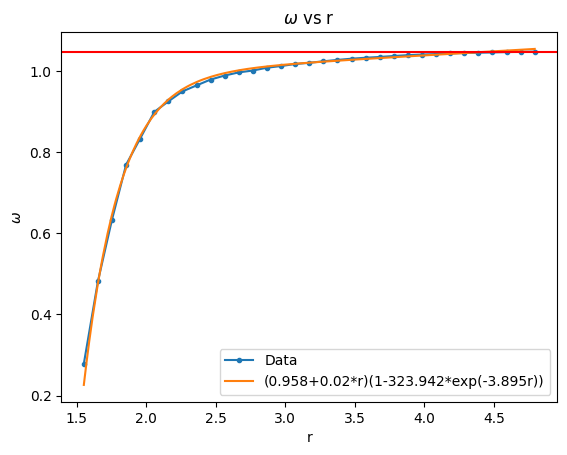

In [16]:
delta = 0.1
df3['rchunk'] = np.floor(df3['r']/delta)+1
chunked_omega = np.asarray(df3.groupby('rchunk')['omega'].mean())
# plt.plot(np.arange(1.5,4.8,0.1), np.abs(np.asarray(chunked_omega)),marker='.')
plt.plot(np.linspace(np.min(df3['r']),np.max(df3['r']),np.shape(chunked_omega)[0]), np.abs(chunked_omega),marker='.')
plt.plot(df3['r'],y)
plt.ylabel('$\omega$')
plt.xlabel('r')
plt.title(r'$\omega$ vs r')
plt.legend(['Data',f'({fit_c1}+{fit_c2}*r)(1-{fit_c3}*exp(-{fit_c4}r))'])
plt.axhline(y=om,c='red')
print('R2 = ', r2_score(np.abs(chunked_omega),fun2(np.linspace(np.min(df3['r']),np.max(df3['r']),np.shape(chunked_omega)[0]),fit_c1,fit_c2,fit_c3,fit_c4)))

### Velocity preliminary analysis and curve fiting

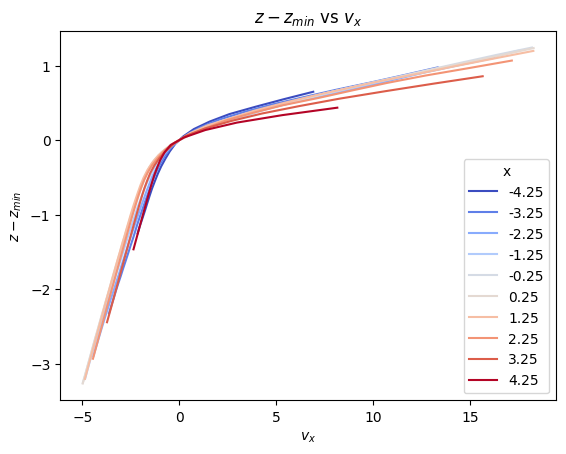

In [17]:
values_to_match = [-4.25, -3.25, -2.25, -1.25, -0.25, 0.25, 1.25, 2.25, 3.25, 4.25]
df3 = df[df['x'].isin(values_to_match)]
df3 = df3[(df3['z']<df3['zmax'])]
df3 = df3[df3['r']<4.85]
sns.lineplot(data=df3, x = df3['vx'],y = df3['z']-df3['zmin'],hue=df3['x'],legend=values_to_match,palette='coolwarm')
plt.title(r'$z-z_{min}$ vs $v_{x}$')
plt.ylabel(r'$z-z_{min}$')
plt.xlabel(r'$v_{x}$')
plt.show()

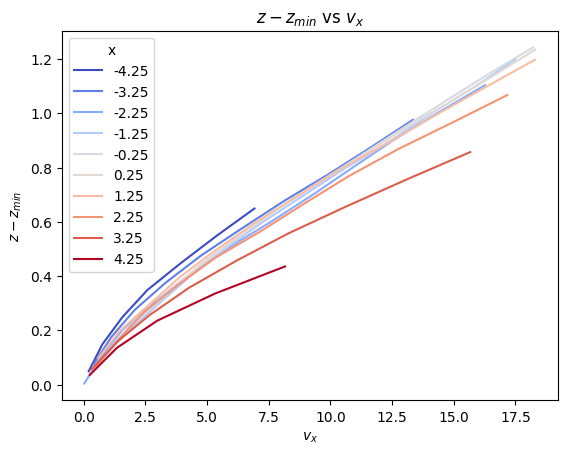

In [18]:
values_to_match = [-4.25, -3.25, -2.25, -1.25, -0.25, 0.25, 1.25, 2.25, 3.25, 4.25]
df3 = df[df['x'].isin(values_to_match)]
df3 = df3[(df3['z']<df3['zmax']) & (df3['z']-df3['zmin']>=0)]
sns.lineplot(data=df3, x = df3['vx'],y = df3['z']-df3['zmin'],hue=df3['x'],legend=values_to_match,palette='coolwarm')
plt.title(r'$z-z_{min}$ vs $v_{x}$')
plt.ylabel(r'$z-z_{min}$')
plt.xlabel(r'$v_{x}$')
plt.show()

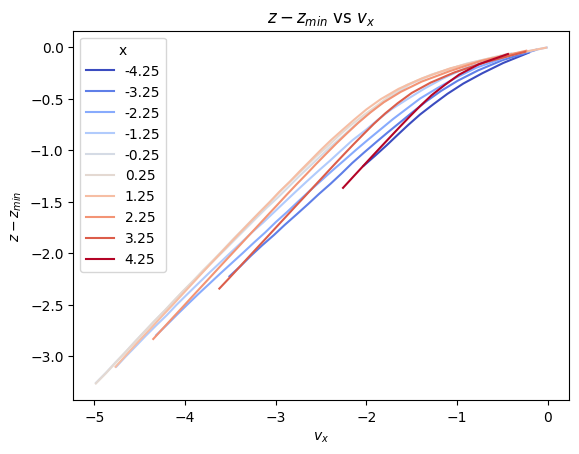

In [19]:
values_to_match = [-4.25, -3.25, -2.25, -1.25, -0.25, 0.25, 1.25, 2.25, 3.25, 4.25]
df3 = df[df['x'].isin(values_to_match)]
df3 = df3[(df3['z']<df3['zmax']) & (df3['z']-df3['zmin']<=0)]
df3 = df3[df3['r']<4.8]
sns.lineplot(data=df3, x = df3['vx'],y = df3['z']-df3['zmin'],hue=df3['x'],legend=values_to_match,palette='coolwarm')
plt.title(r'$z-z_{min}$ vs $v_{x}$')
plt.ylabel(r'$z-z_{min}$')
plt.xlabel(r'$v_{x}$')
plt.show()

In [20]:
#for fitting vx
def fun2(y,a,b):
    return a*y*(1-np.exp(-b*y))

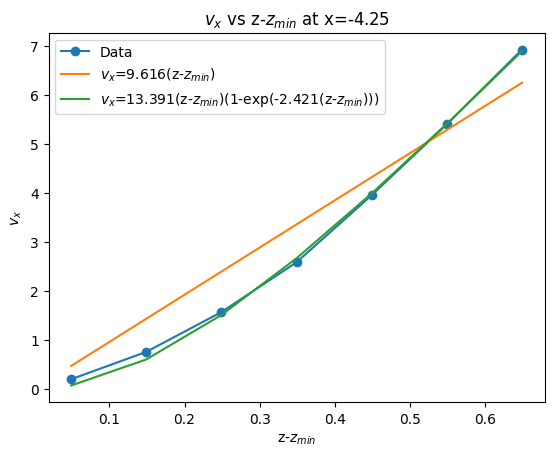

0.10399074741154961 R2= 0.9068570321729771
13.391 2.421 R2= 0.9985785412572106


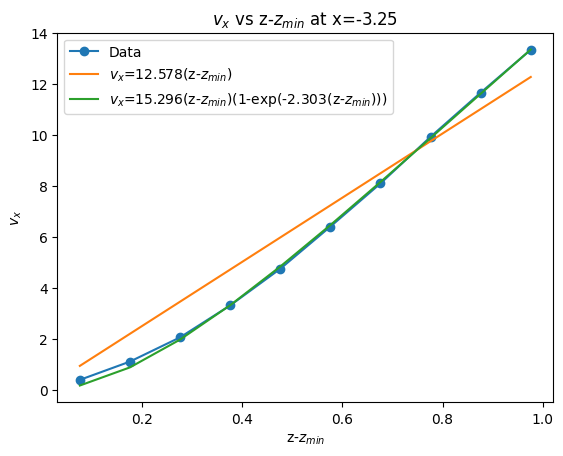

0.07950182972313714 R2= 0.9283021811777827
15.296 2.303 R2= 0.9993104944801433


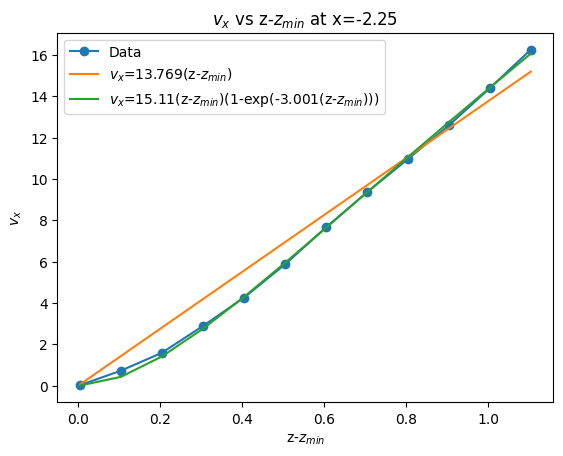

0.07262656101345896 R2= 0.968198944750223
15.11 3.001 R2= 0.9993517952586048


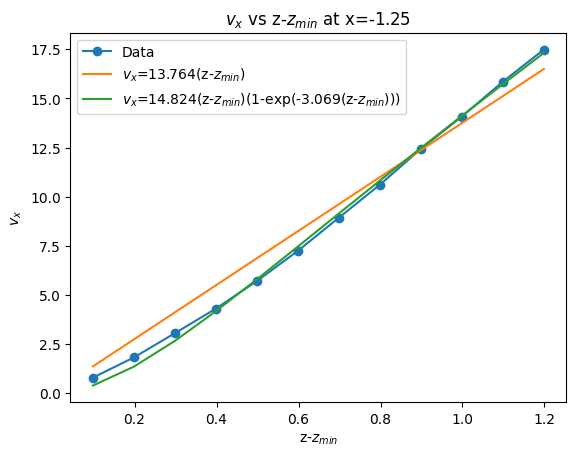

0.07265501503831669 R2= 0.9693587839635769
14.824 3.069 R2= 0.9978484888537655


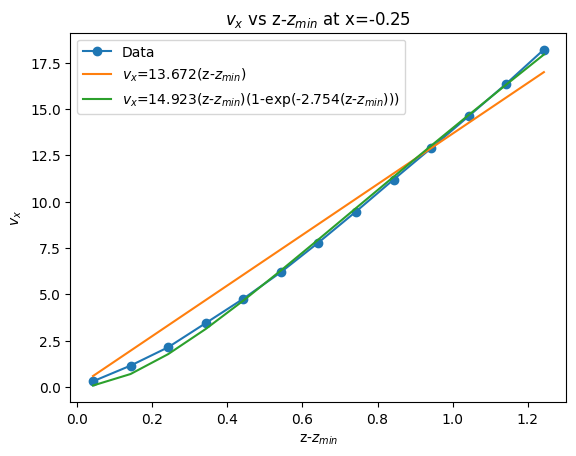

0.07314044386577837 R2= 0.9687523704716695
14.923 2.754 R2= 0.9983733547731626


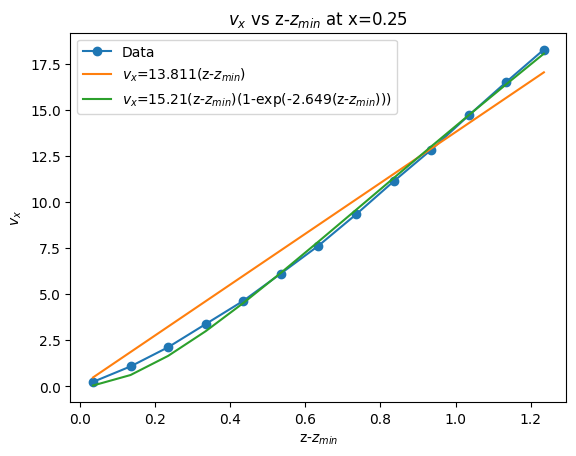

0.07240579482717589 R2= 0.966953115317389
15.21 2.649 R2= 0.9979760235897029


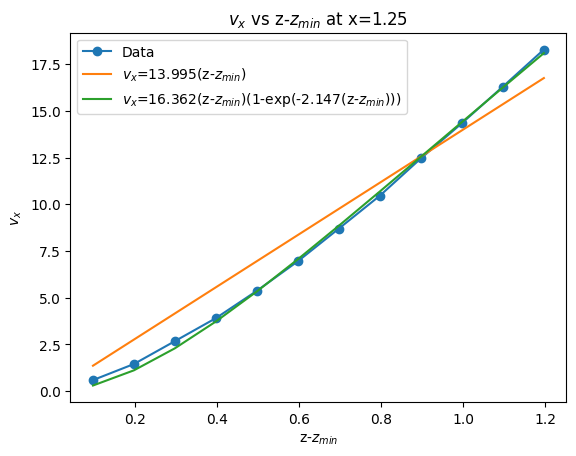

0.07145381323099918 R2= 0.940367855302668
16.362 2.147 R2= 0.9986807350371503


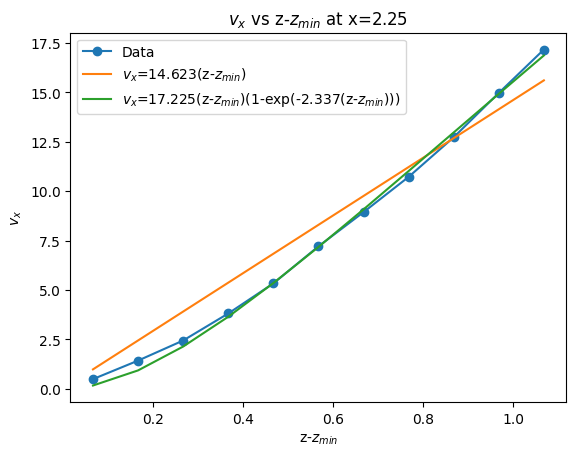

0.06838596369726076 R2= 0.9433019097320776
17.225 2.337 R2= 0.997702797148572


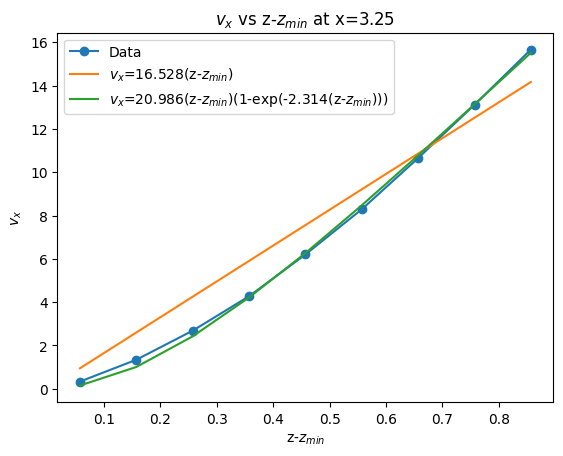

0.06050458764357831 R2= 0.9242612789001164
20.986 2.314 R2= 0.9987290417604769


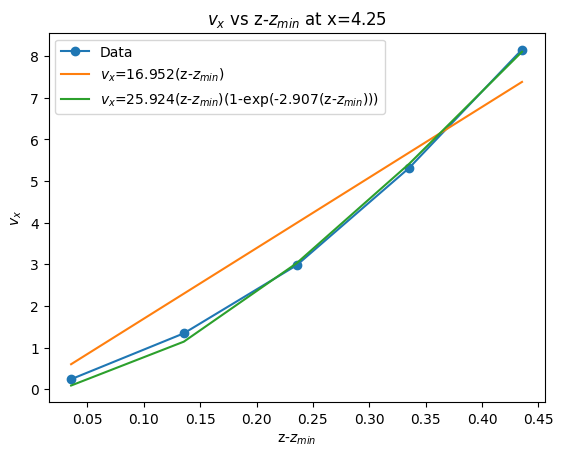

0.058989486782457384 R2= 0.9022609538539843
25.924 2.907 R2= 0.998073164462211


In [21]:
values_to_match = [-4.25, -3.25, -2.25, -1.25, -0.25, 0.25, 1.25, 2.25, 3.25, 4.25]
df3 = df[df['x'].isin(values_to_match)]
df3 = df3[(df3['z']<df3['zmax']) & (df3['z']-df3['zmin']>=0)]

inv_gamma_dot = []
a_values = []
b_values = []

for xcoord in values_to_match:
    df4 = df3[df3['x']==xcoord]
    df4 = df4[df4['z']-df4['zmin']>=0]
    df_line = df4

    vx = np.asarray(df_line['vx'])
    vx = vx.reshape(-1,1)#[:,np.newaxis]
    m,_,_,_ = np.linalg.lstsq(vx,df_line['z']-df4['zmin'],rcond=None)
    m=m[0]
    plt.plot(df4['z']-df4['zmin'],df4['vx'],marker='o')
    plt.plot(df_line['z']-df_line['zmin'],1/m*(df_line['z']-df_line['zmin']))

    par,cov = curve_fit(fun2,df4['z']-df4['zmin'],df4['vx'])
    a,b=np.round(par,3)
    plt.plot(df4['z']-df4['zmin'],fun2(df4['z']-df4['zmin'],a,b))
    plt.xlabel('z-$z_{{min}}$')
    plt.ylabel('$v_{{x}}$')
    plt.title(f'$v_{{x}}$ vs z-$z_{{min}}$ at x={xcoord}')
    plt.legend(['Data',f'$v_{{x}}$={np.round(1/m,3)}(z-$z_{{min}}$)',f'$v_{{x}}$={a}(z-$z_{{min}}$)(1-exp(-{b}(z-$z_{{min}}$)))'])
    plt.show()
    print(m,'R2=',r2_score(df_line['z']-df_line['zmin'],m*df_line['vx']))
    print(a,b,'R2=',r2_score(df4['vx'],fun2(df4['z']-df4['zmin'],a,b)))

    inv_gamma_dot.append(m)
    a_values.append(a)
    b_values.append(b)

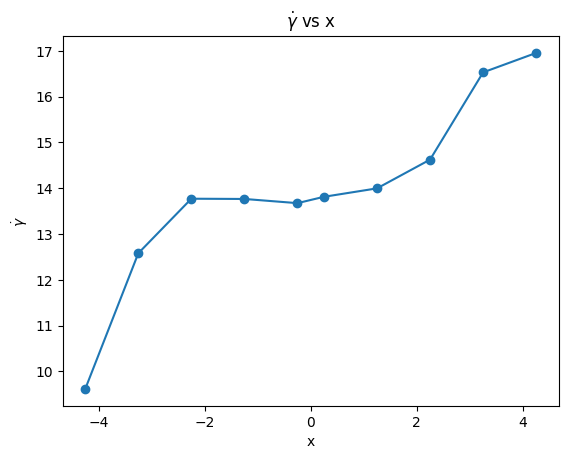

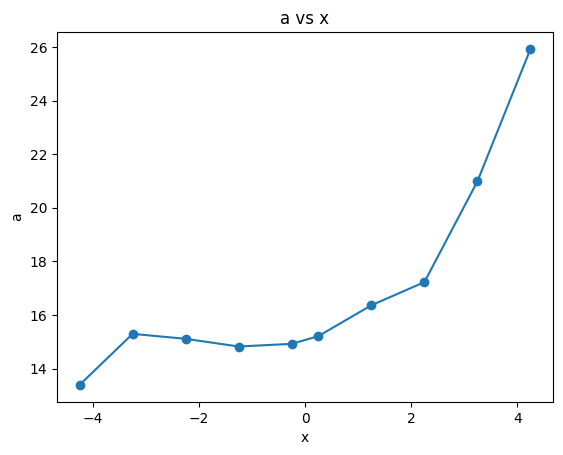

2.5902000000000003


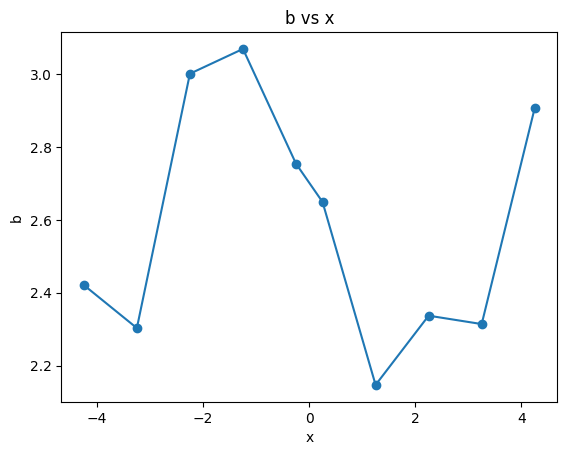

In [22]:
gamma_dot = 1/np.array(inv_gamma_dot)
plt.plot(values_to_match,gamma_dot,marker='o')
plt.xlabel('x')
plt.ylabel(r'$\dot{\gamma}$')
plt.title(r'$\dot{\gamma}$ vs x')
plt.show()
plt.plot(values_to_match,a_values,marker='o')
plt.xlabel('x')
plt.ylabel('a')
plt.title('a vs x')
plt.show()
plt.plot(values_to_match,b_values,marker='o')
plt.xlabel('x')
plt.ylabel('b')
plt.title('b vs x')
print(np.mean(b_values))

In [23]:
print(gamma_dot)
print(a_values)
print(b_values)
print(np.mean(gamma_dot[1:-1]))
print(np.mean(a_values[1:-1]))
print(np.mean(b_values[1:-1]))

[ 9.61624015 12.57832686 13.76906721 13.76367481 13.67232611 13.81104927
 13.99505435 14.62288379 16.52767235 16.95217325]
[13.391, 15.296, 15.11, 14.824, 14.923, 15.21, 16.362, 17.225, 20.986, 25.924]
[2.421, 2.303, 3.001, 3.069, 2.754, 2.649, 2.147, 2.337, 2.314, 2.907]
14.092506842940336
16.242
2.5717499999999998


### Hypothetical Inteface

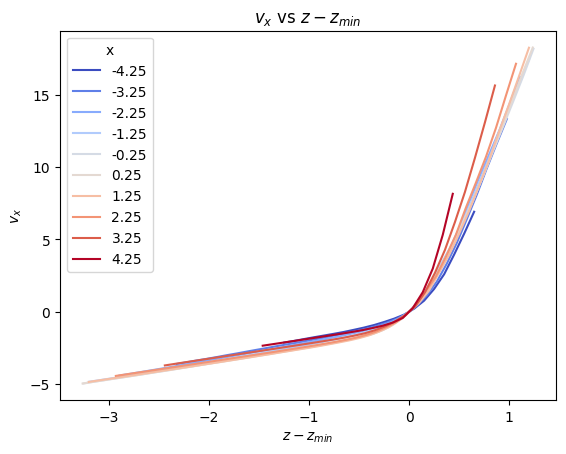

In [24]:
values_to_match = [-4.25, -3.25, -2.25, -1.25, -0.25, 0.25, 1.25, 2.25, 3.25, 4.25]
df3 = df[df['x'].isin(values_to_match)]
df3 = df3[(df3['z']<df3['zmax'])]
df3 = df3[df3['r']<4.85]
sns.lineplot(data=df3, x = df3['z']-df3['zmin'],y = df3['vx'],hue=df3['x'],legend=values_to_match,palette='coolwarm')
plt.title(r'$v_{x}$ vs $z-z_{min}$')
plt.ylabel(r'$v_{x}$')
plt.xlabel(r'$z-z_{min}$')
plt.show()

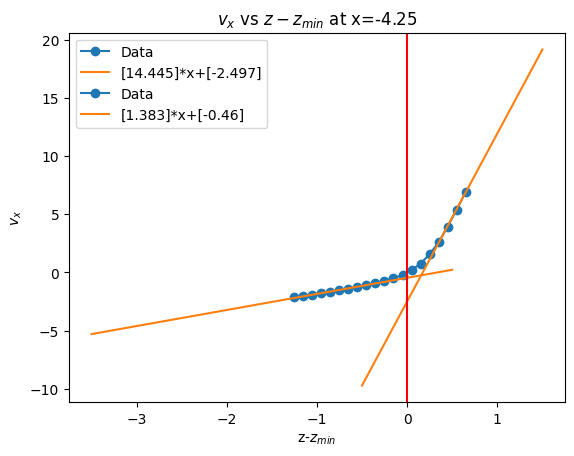

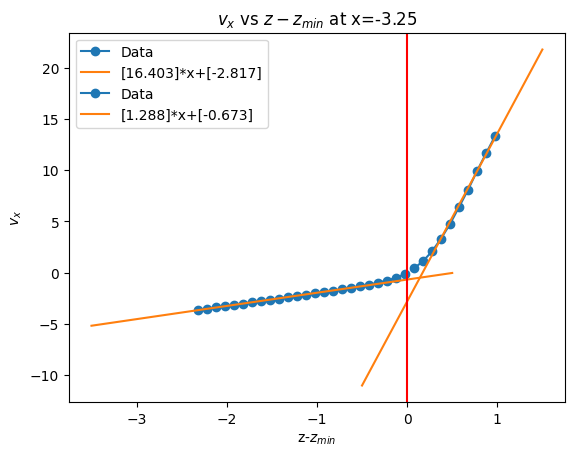

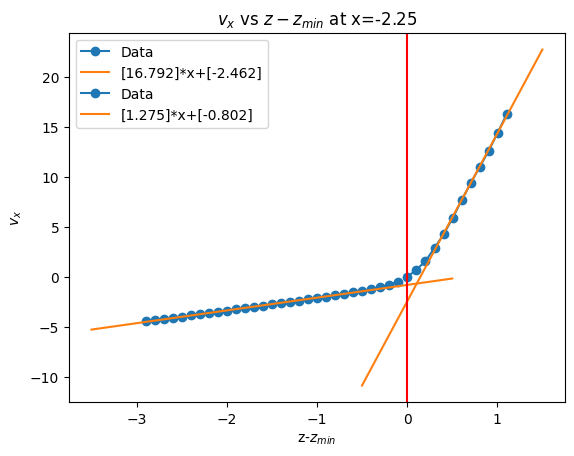

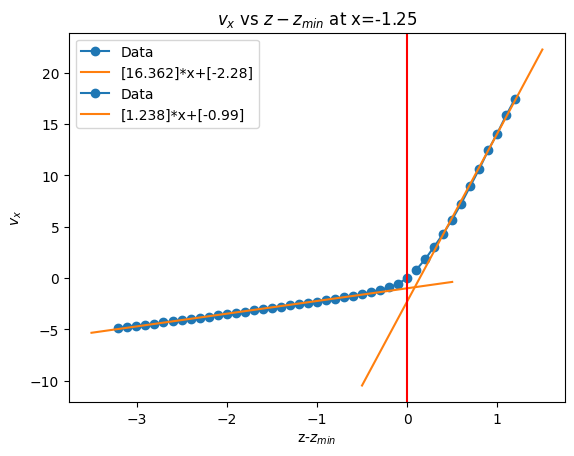

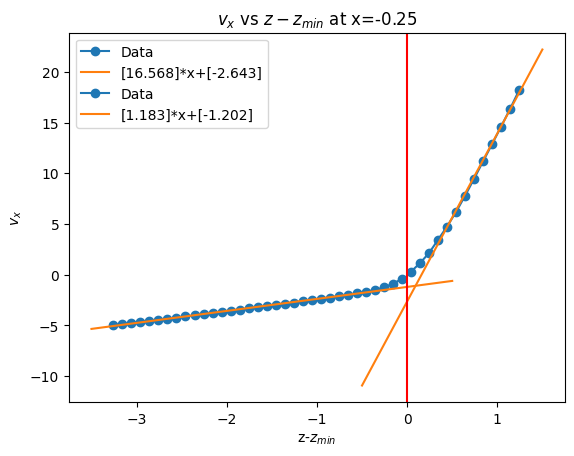

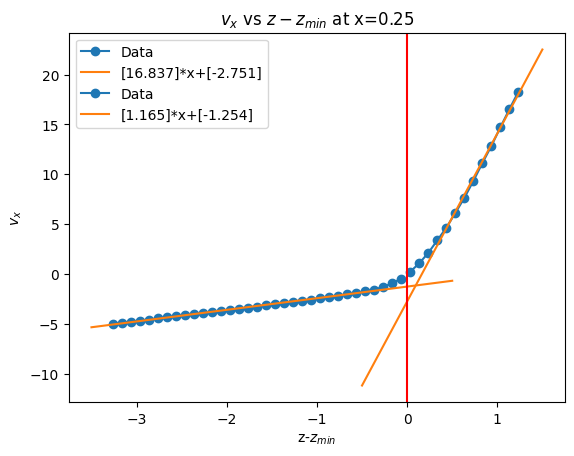

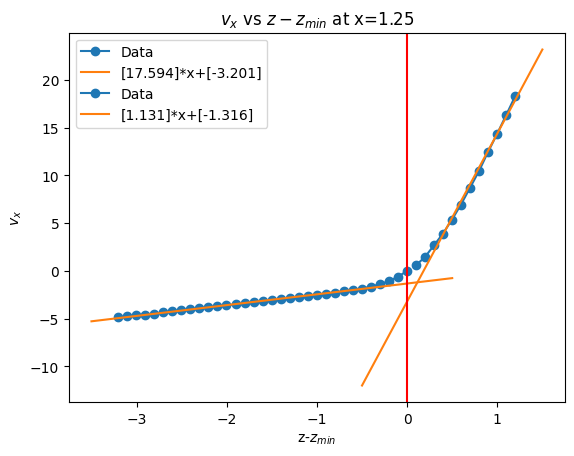

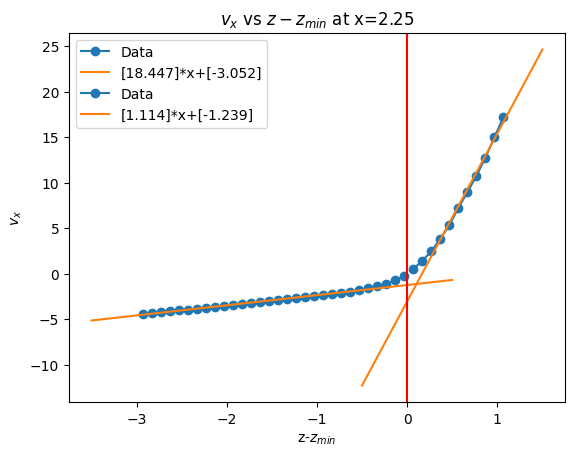

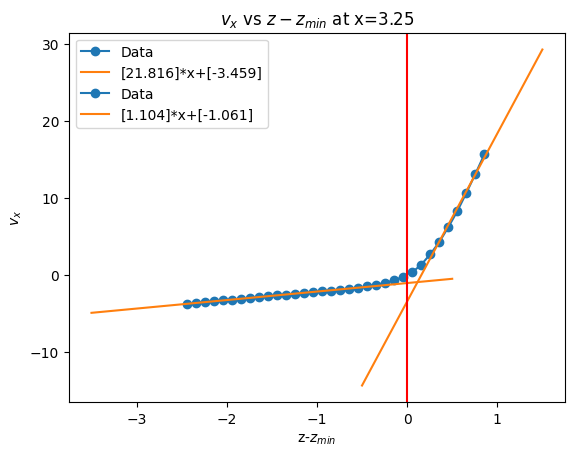

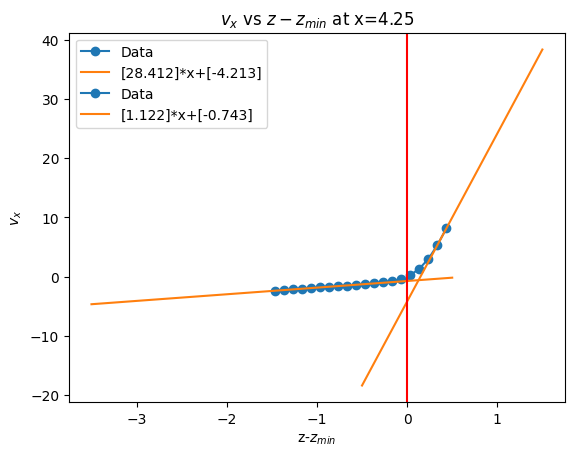

In [25]:
values_to_match = [-4.25, -3.25, -2.25, -1.25, -0.25, 0.25, 1.25, 2.25, 3.25, 4.25]
df3 = df[df['x'].isin(values_to_match)]
df3 = df3[df3['r']<4.85]
int_points_df = pd.DataFrame(columns = ['xcoord','m1','b1','m2','b2','int_z_zmin','int_vx'])

for xcoord in values_to_match:
    df4 = df3[(df3['z']<df3['zmax']) & (df3['z']-df3['zmin']>=0)]
    df4 = df4[df4['x']==xcoord]
    df_line = df4[df4['z']-df4['zmin']>=0.25]

    vx = np.asarray(df_line['vx'])
    vx = vx.reshape(-1,1)
    m1,b1 = np.polyfit(df_line['z']-df_line['zmin'],vx,1)
    plt.plot(df4['z']-df4['zmin'],df4['vx'],marker='o')
    plt.plot(np.linspace(-0.5,1.5,50),m1*np.linspace(-0.5,1.5,50)+b1,c='tab:orange')
    legend = ['Data',f'{np.round(m1,3)}*x+{np.round(b1,3)}']

    plt.xlabel('z-zmin')
    plt.ylabel('vx')
    plt.title(f'vx vs z-z_min at x={xcoord}')
    ################################################################################
    df4 = df3[(df3['z']<df3['zmax']) & (df3['z']-df3['zmin']<=0)]
    df4 = df4[(df4['x']==xcoord)]
    df_line = df4[(df4['z']-df4['zmin']<=-0.25)]

    vx = np.asarray(df_line['vx'])
    vx = vx.reshape(-1,1)
    m2,b2 = np.polyfit(df_line['z']-df_line['zmin'],vx,1)
    plt.plot(df4['z']-df4['zmin'],df4['vx'],c='tab:blue',marker='o')
    plt.plot(np.linspace(-3.5,0.5,50),m2*np.linspace(-3.5,0.5,50)+b2)
    legend.append('Data')
    legend.append(f'{np.round(m2,3)}*x+{np.round(b2,3)}')

    plt.xlabel('z-$z_{min}$')
    plt.ylabel('$v_{x}$')
    plt.title(f'$v_{{x}}$ vs $z-z_{{min}}$ at x={xcoord}')
    plt.axvline(x=0,c='red')
    plt.legend(legend)
    plt.show()

    m1 = m1[0]; b1 = b1[0]; m2 = m2[0]; b2 = b2[0]
    A_matrix = [[1,-m1],[1,-m2]]
    b_matrix = [b1,b2]
    int_y,int_x = np.linalg.solve(A_matrix,b_matrix)
    int_points_df.loc[len(int_points_df)] = [xcoord,m1,b1,m2,b2,int_x, int_y]

In [26]:
for i in range(len(int_points_df)):
    for x in zmin_dict.keys():
        if int_points_df.loc[i,'xcoord'] == np.round(x,2):
            int_points_df.loc[i,'new_zmin'] = int_points_df.loc[i,'int_z_zmin']+zmin_dict[x]
            int_points_df.loc[i,'old_zmin'] = zmin_dict[x]
int_points_df

,xcoord,m1,b1,m2,b2,int_z_zmin,int_vx,new_zmin,old_zmin
0,-4.25,14.445340,-2.496615,1.382556,-0.459574,0.155942,-0.243975,-0.843123,-0.999065
1,-3.25,16.403190,-2.817161,1.287739,-0.673274,0.141834,-0.490629,-1.084188,-1.226022
2,-2.25,16.791542,-2.461655,1.275463,-0.802044,0.106961,-0.665620,-1.246936,-1.353897
3,-1.25,16.362130,-2.280102,1.238291,-0.989937,0.085307,-0.884302,-1.363245,-1.448552
4,-0.25,16.568240,-2.642628,1.183194,-1.201803,0.093651,-1.090996,-1.398937,-1.492588
5,0.25,16.836536,-2.750916,1.164842,-1.253822,0.095529,-1.142546,-1.389529,-1.485058
6,1.25,17.593736,-3.201438,1.130647,-1.316311,0.114506,-1.186845,-1.332694,-1.447200
7,2.25,18.446550,-3.052083,1.113525,-1.239444,0.104577,-1.122995,-1.212942,-1.317519
8,3.25,21.815911,-3.458978,1.104472,-1.061066,0.115777,-0.933194,-0.991395,-1.107173
9,4.25,28.412300,-4.213135,1.122297,-0.742579,0.127173,-0.599853,-0.658339,-0.785512


Text(0.5, 1.0, '$z_{min}$ vs x')

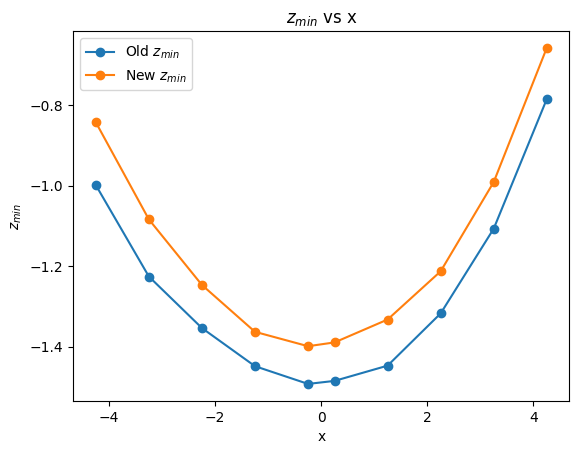

In [27]:
plt.plot(int_points_df['xcoord'],int_points_df['old_zmin'],marker='o',label=r'Old $z_{min}$')
plt.plot(int_points_df['xcoord'],int_points_df['new_zmin'],marker='o',label=r'New $z_{min}$')
plt.xlabel('x')
plt.ylabel(r'$z_{min}$')
plt.legend()
plt.title(r'$z_{min}$ vs x')

In [28]:
print(np.asarray(int_points_df['old_zmin']))
print(np.asarray(int_points_df['new_zmin']))

[-0.9990651  -1.22602204 -1.35389661 -1.44855196 -1.49258797 -1.48505763
 -1.44719983 -1.31751925 -1.10717264 -0.78551225]
[-0.84312278 -1.08418792 -1.24693593 -1.3632452  -1.39893699 -1.38952906
 -1.33269358 -1.21294207 -0.99139545 -0.6583391 ]


### Streamlines

In [31]:
df.head()

,x,z,vx,vy,vz,phi,r,omega,theta,zmin,zmax
138,-4.85,-1.15,0.000000,0.000000,0.00000,0.000000,4.984476,0.000000,-166.660751,-0.62307,-0.485434
139,-4.85,-1.05,-0.059106,-0.003958,0.29458,0.000196,4.962358,-0.060539,-167.784281,-0.62307,-0.485434
140,-4.85,-0.95,-0.761397,-0.059851,4.09325,0.223367,4.942166,-0.842399,-168.917431,-0.62307,-0.485434
141,-4.85,-0.85,-0.622439,-0.033657,3.93112,0.425013,4.923921,-0.808208,-170.059427,-0.62307,-0.485434
142,-4.85,-0.75,-0.457275,-0.037318,3.65518,0.454823,4.907647,-0.750284,-171.209457,-0.62307,-0.485434


In [32]:
vx_array = np.zeros((400,400))
vz_array = np.zeros((400,400))
for row in df.index:
    i = int(np.trunc((df.at[row,'x']+R)/0.1)) + 1
    j = int(np.trunc((df.at[row,'z']+R)/0.1)) + 1
    vx_array[i][j] = df.at[row,'vx']
    vz_array[i][j] = df.at[row,'vz']

In [34]:
def integrate_streamline(x0, z0, steps, dt):
    x = np.zeros(steps)
    z = np.zeros(steps)
    x[0] = x0
    z[0] = z0

    vx = np.zeros(steps)
    vz = np.zeros(steps)
    i0 = int(np.trunc((x0+R)/0.1)) + 1
    j0 = int(np.trunc((z0+R)/0.1)) + 1
    vx[0] = vx_array[i0][j0]
    vz[0] = vz_array[i0][j0]

    for n in range(1, steps):
        # get velocities at current position
        vx[n], vz[n] = interpolate_velocity(x[n-1], z[n-1])

        x[n] = x[n-1] + vx[n] * dt
        z[n] = z[n-1] + vz[n] * dt

        # Check if new position is out of bounds
        if x[n] < df['x'].min() or x[n] > df['x'].max() or z[n] < df['z'].min() or z[n] > df['z'].max():
            break

    return x[:n], z[:n], vx[:n], vz[:n]

def interpolate_velocity(x, z):
    # get indices of grid points
    i = int(np.trunc((x+R)/0.1)) + 1
    j = int(np.trunc((z+R)/0.1)) + 1

    # coordinates at centre of grid point
    x_i = (i-0.5)*0.1-R
    z_j = (j-0.5)*0.1-R

    # derivatives in central difference
    dvx_dx = (vx_array[i+1][j] - vx_array[i-1][j])/(2*delx)
    dvx_dz = (vx_array[i][j+1] - vx_array[i][j-1])/(2*delz)
    dvz_dx = (vz_array[i+1][j] - vz_array[i-1][j])/(2*delx)
    dvz_dz = (vz_array[i][j+1] - vz_array[i][j-1])/(2*delz)

    vx = vx_array[i][j] + dvx_dx*(x-x_i) + dvx_dz*(z-z_j)
    vz = vz_array[i][j] + dvz_dx*(x-x_i) + dvz_dz*(z-z_j)
    return vx, vz

# Starting point of streamline
x0 = 1
# z0 = -0.2
dt = 1e-3
steps = int(1e4)
delx = 0.05
delz = 0.05

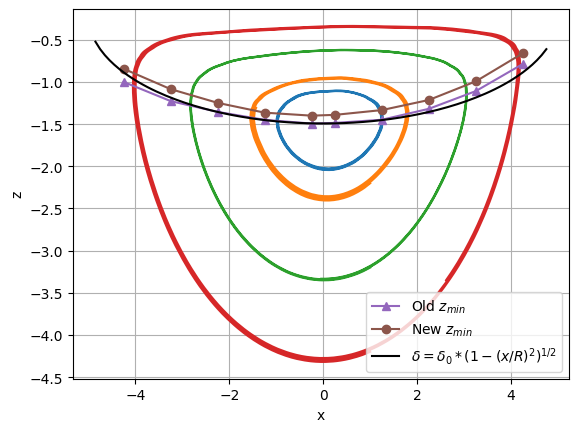

In [35]:
# for z0 in [-0.2,-1.2,-2.2,-3.2,-4.2]:
for z0 in [-1.2,-2.2,-3.2,-4.2]:

    # Integrate streamline
    x_streamline, z_streamline, vx_streamline, vz_streamline = integrate_streamline(x0, z0, steps, dt)

    initial_point_index = np.where(np.isclose(x_streamline, x0) & np.isclose(z_streamline, z0))[0]
    if initial_point_index.size > 1:
        # Extract the streamline up to the initial point
        x_streamline = x_streamline[:initial_point_index[0]+1]
        z_streamline = z_streamline[:initial_point_index[0]+1]

    # Plot the streamline
    import matplotlib.pyplot as plt
    plt.plot(x_streamline, z_streamline)
    plt.xlabel('x')
    plt.ylabel('z')
    # plt.title(f'Streamline starting at ({x0},{z0})')
    plt.grid(True)
    # plt.show()

plt.plot(int_points_df['xcoord'],int_points_df['old_zmin'],marker = '^',label=r'Old $z_{min}$')
plt.plot(int_points_df['xcoord'],int_points_df['new_zmin'],marker='o',label=r'New $z_{min}$')

delta = np.min(df['zmin']-df['zmax'])*np.sqrt(1-(df['x']**2)/R**2)
plt.plot(df['x'],delta-0.21,c='black',label=r'$\delta = \delta_{0}*(1-(x/R)^2)^{1/2}$')
plt.legend()

### Curve fitting to streamlines; corner points

-1.364847961626495 -0.020198741804952732


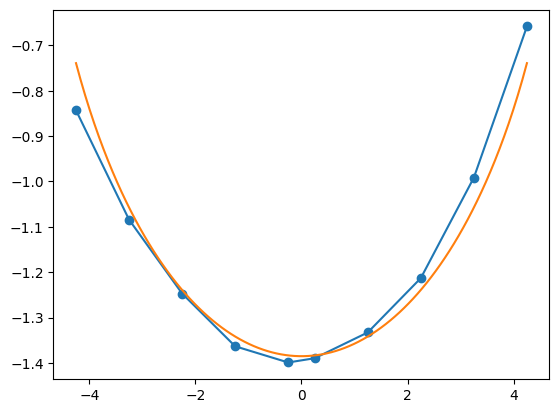

In [37]:
def int_curve(x,a,b):
    zmin = a*np.sqrt(1-(x/R)**2) + b
    return zmin

par,cov = curve_fit(int_curve,int_points_df['xcoord'],int_points_df['new_zmin'])
a,b = par
plt.plot(int_points_df['xcoord'],int_points_df['new_zmin'],marker='o')
plt.plot(np.linspace(-4.25,4.25,100),int_curve(np.linspace(-4.25,4.25,100),a,b))
print(a,b)

In [38]:
def find_max_angle_points(x, z, u, w):
    max_angle_pos = -np.inf
    max_angle_point_pos = None
    max_angle_neg = -np.inf
    max_angle_point_neg = None

    # Find max angle for x > 0
    for i in range(len(x)-1):
        if x[i] > 0 and x[i+1] > 0:
            vec1 = np.array([u[i], w[i]])
            vec2 = np.array([u[i+1], w[i+1]])
            cosine_angle = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
            angle = np.arccos(np.clip(cosine_angle, -1, 1))
            if angle > max_angle_pos:
                max_angle_pos = angle
                max_angle_point_pos = (x[i], z[i])

    # Find max angle for x < 0
    for i in range(len(x)-1):
        if x[i] < 0 and x[i+1] < 0:
            vec1 = np.array([u[i], w[i]])
            vec2 = np.array([u[i+1], w[i+1]])
            cosine_angle = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
            angle = np.arccos(np.clip(cosine_angle, -1, 1))
            if angle > max_angle_neg:
                max_angle_neg = angle
                max_angle_point_neg = (x[i], z[i])

    return max_angle_point_pos, np.degrees(max_angle_pos), max_angle_point_neg, np.degrees(max_angle_neg)

In [39]:
x0 = 1
# z0 = -0.2
dt = 1e-3
steps = int(1e4)
delx = 0.05
delz = 0.05
stream_corner_points = pd.DataFrame(columns=['x0','z0','xpos','zpos','xneg','zneg'])
# for z0 in [-0.2,-1.2,-2.2,-3.2,-4.2]:
for z0 in [-1.2,-2.2,-3.2,-4.2]:
    x_streamline, z_streamline, vx_streamline, vz_streamline = integrate_streamline(x0, z0, steps, dt)
    max_angle_point_pos, max_angle_pos, max_angle_point_neg, max_angle_neg = find_max_angle_points(x_streamline, z_streamline, vx_streamline, vz_streamline)
    stream_corner_points.loc[len(stream_corner_points)] = [x0,z0,max_angle_point_pos[0],max_angle_point_pos[1],max_angle_point_neg[0],max_angle_point_neg[1]]

stream_corner_points

,x0,z0,xpos,zpos,xneg,zneg
0,1.0,-1.2,1.225437,-1.400738,-0.971439,-1.398923
1,1.0,-2.2,1.743245,-1.300914,-1.504894,-1.299361
2,1.0,-3.2,3.021865,-1.001848,-2.787512,-1.097581
3,1.0,-4.2,4.067489,-0.601428,-3.988753,-0.797364


Text(0.5, 1.0, 'Possible definitions of the interface')

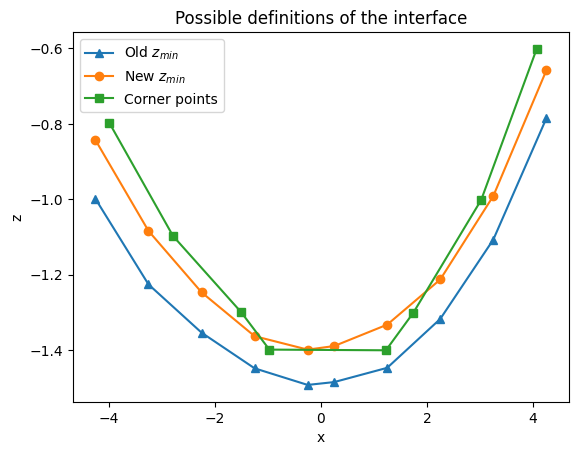

In [40]:
x_corner = np.array(pd.concat([stream_corner_points['xpos'],stream_corner_points['xneg']]))
z_corner = np.array(pd.concat([stream_corner_points['zpos'],stream_corner_points['zneg']]))

sorted_indices = np.argsort(x_corner)
x_corner = x_corner[sorted_indices]
z_corner = z_corner[sorted_indices]

plt.plot(int_points_df['xcoord'],int_points_df['old_zmin'],marker = '^',label = 'Old $z_{min}$')
plt.plot(int_points_df['xcoord'],int_points_df['new_zmin'],marker='o',label = 'New $z_{min}$')
plt.plot(x_corner,z_corner,marker='s',label = 'Corner points')

par,cov = curve_fit(int_curve,x_corner,z_corner)
a,b = par

plt.legend()
plt.xlabel('x')
plt.ylabel('z')
plt.title('Possible definitions of the interface')

### Tangent and normal

In [41]:
# in case of smooth function
def derivative_normal_int_curve(x):
    zmin = int_curve(x,a,b) # change depending on what you want the smooth approx to zmin to be
    tgt = a/(2*np.sqrt(1-(x/R)**2))*(-2*x/(R**2))
    normal = -1/tgt
    return [zmin,tgt,normal]

int_velocity_df = pd.DataFrame(columns = ['xcoord','zmin','vx','vz','tgt_slope','normal_slope','v_tgt','v_normal'])

for x0 in values_to_match:
    zmin,tgt,normal = derivative_normal_int_curve(x0)

    vx,vz = interpolate_velocity(x0,zmin)
    v_vec = np.array([vx,vz])
    normal_vec = np.array([1,normal])
    tgt_vec = np.array([1,tgt])
    v_normal = np.dot(v_vec, normal_vec)/np.linalg.norm(normal_vec)
    v_tgt = np.dot(v_vec, tgt_vec)/np.linalg.norm(tgt_vec)

    int_velocity_df.loc[len(int_velocity_df)] = [x0,zmin,vx,vz,tgt,normal,v_tgt,v_normal]

int_velocity_df['tgt_angle'] = np.arctan(int_velocity_df['tgt_slope'])*180/np.pi
int_velocity_df

,xcoord,zmin,vx,vz,tgt_slope,normal_slope,v_tgt,v_normal,tgt_angle
0,-4.25,-0.565484,3.516513,2.460514,-0.578897,1.727422,1.810622,3.891226,-30.066436
1,-3.25,-0.983721,1.331724,2.860521,-0.306868,3.258731,0.433950,3.125342,-17.059570
2,-2.25,-1.222471,1.151325,2.159196,-0.180785,5.531446,0.748837,2.329575,-10.247508
3,-1.25,-1.357399,0.649414,1.346756,-0.092634,10.795220,0.522423,1.400916,-5.292410
4,-0.25,-1.412117,0.882197,0.322201,-0.017961,55.676551,0.876268,0.337992,-1.028972
5,0.25,-1.412117,0.824205,-0.055949,0.017961,-55.676551,0.823068,0.070742,1.028972
6,1.25,-1.357399,0.481312,-1.089739,0.092634,-10.795220,0.378744,1.129489,5.292410
7,2.25,-1.222471,0.952459,-1.965963,0.180785,-5.531446,0.587520,2.104046,10.247508
8,3.25,-0.983721,0.546586,-2.952822,0.306868,-3.258731,-0.343721,2.983248,17.059570
9,4.25,-0.565484,2.362085,-3.146995,0.578897,-1.727422,0.467598,3.906965,30.066436


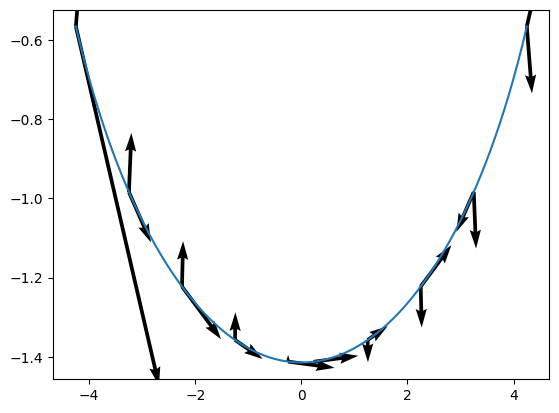

In [42]:
x = int_velocity_df['xcoord']
z = int_velocity_df['zmin']

v_normal = int_velocity_df['v_normal']
normal = int_velocity_df['normal_slope']
v_tgt = int_velocity_df['v_tgt']
tgt = int_velocity_df['tgt_slope']

vnx = v_normal*1/np.sqrt(1+normal**2) # x component of normal velocity
vnz = v_normal*normal/np.sqrt(1+normal**2) # y component of normal velocity
vtx = v_tgt*1/np.sqrt(1+tgt**2)
vtz = v_tgt*tgt/np.sqrt(1+tgt**2)

plt.quiver(x, z, vnx, vnz, angles='xy', scale_units='xy', scale=20)
plt.quiver(x, z, vtx, vtz, angles='xy', scale_units='xy', scale=1)
plt.plot(np.linspace(-4.25,4.25,100),int_curve(np.linspace(-4.25,4.25,100),a,b))
# plt.plot(np.linspace(1.245,1.255,100), -1.341707-14.18833*(np.linspace(1.245,1.255,100)-1.25))

Text(0.5, 1.0, 'Normal velocity vs slope of tangent at interface')

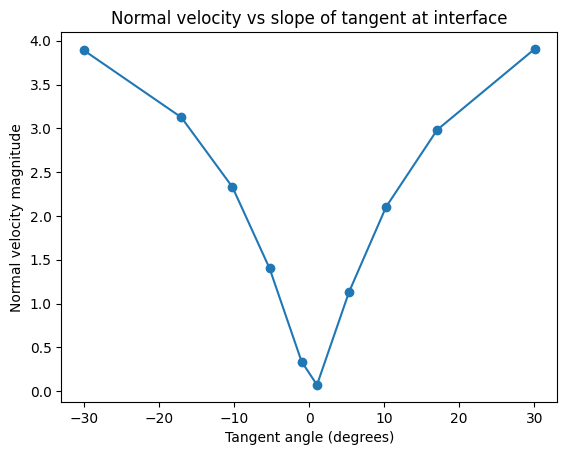

In [43]:
plt.plot(int_velocity_df['tgt_angle'],int_velocity_df['v_normal'],marker='o')
plt.xlabel('Tangent angle (degrees)')
plt.ylabel('Normal velocity magnitude')
plt.title('Normal velocity vs slope of tangent at interface')

In [44]:
print(np.asarray(int_velocity_df['tgt_angle']))
print(np.asarray(int_velocity_df['v_normal']))

[-30.06643621 -17.05957012 -10.24750803  -5.29241023  -1.02897214
   1.02897214   5.29241023  10.24750803  17.05957012  30.06643621]
[3.89122629 3.12534155 2.32957531 1.40091579 0.33799163 0.07074152
 1.1294886  2.10404648 2.98324841 3.90696465]


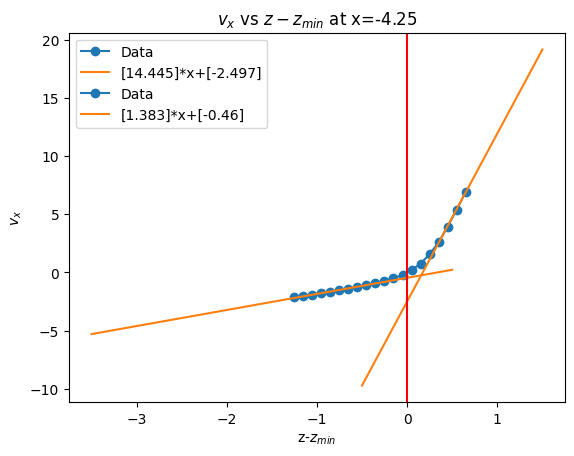

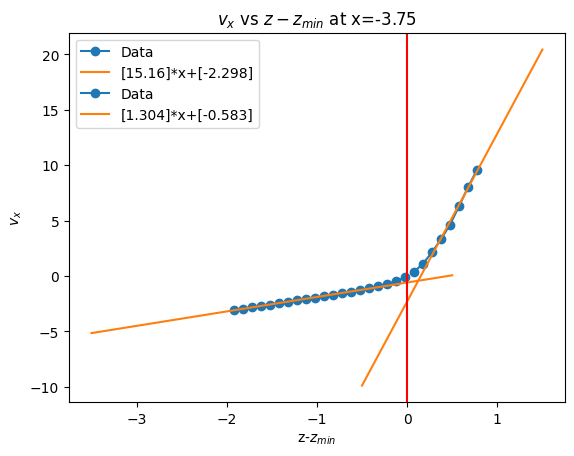

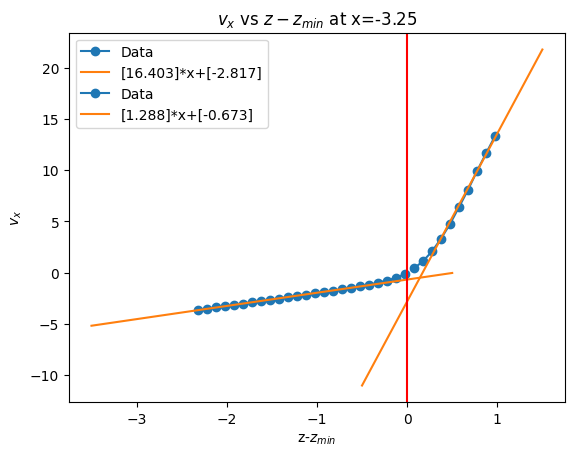

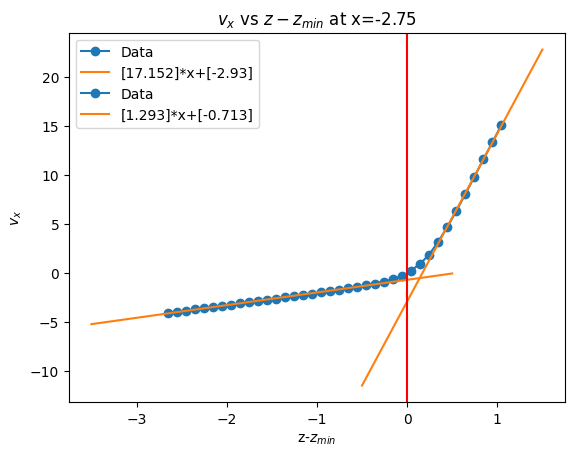

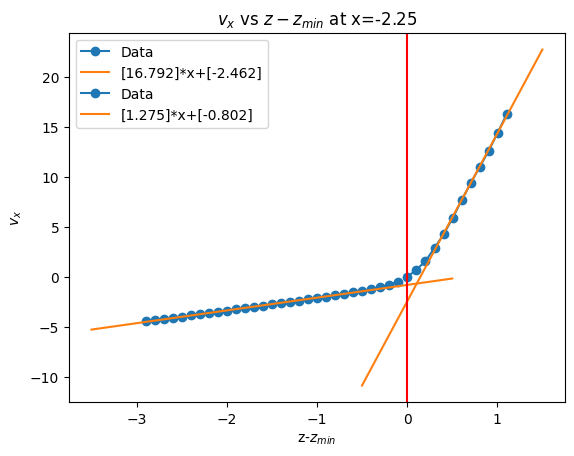

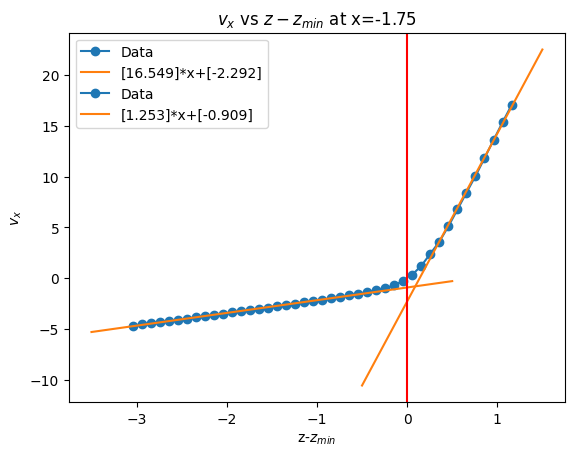

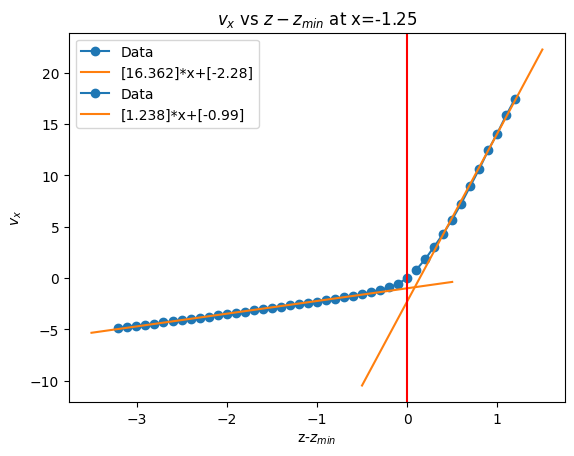

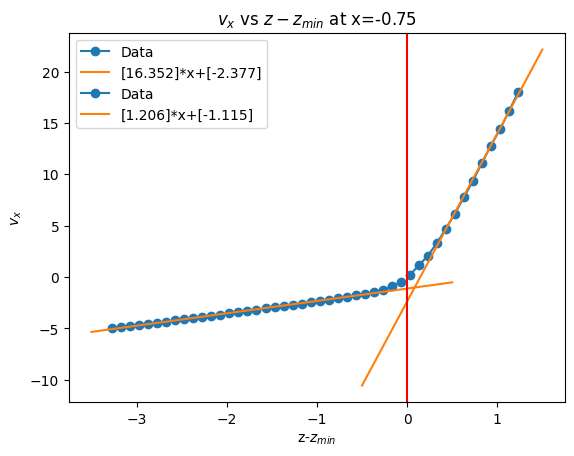

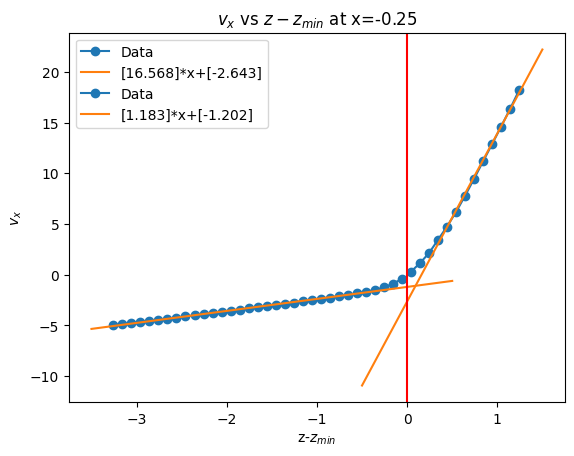

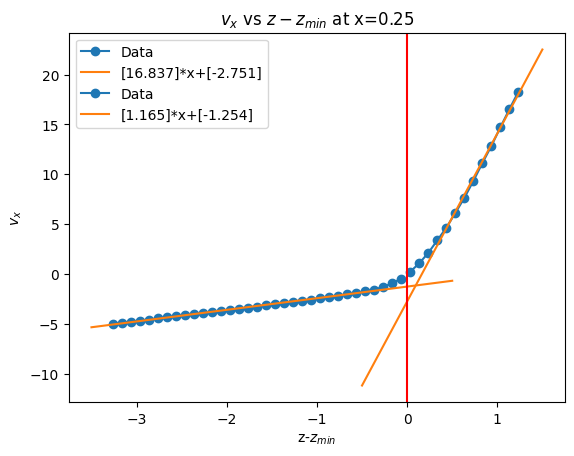

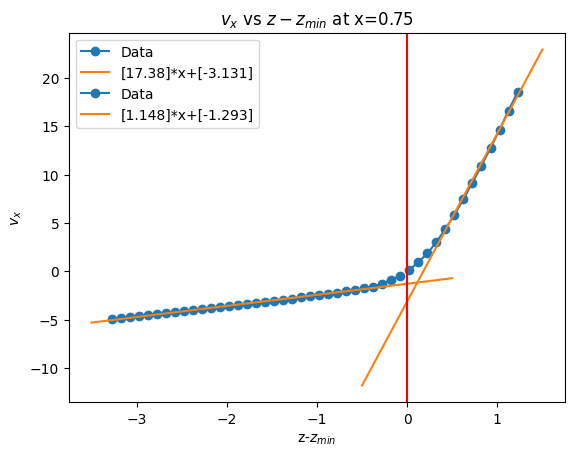

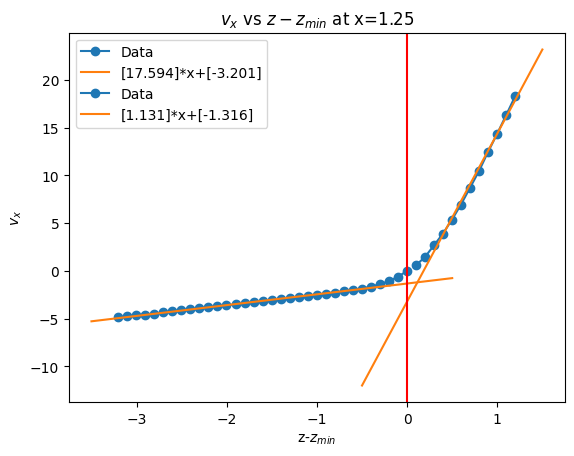

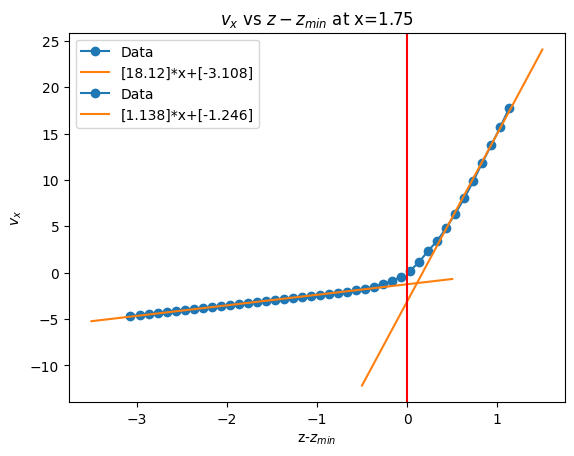

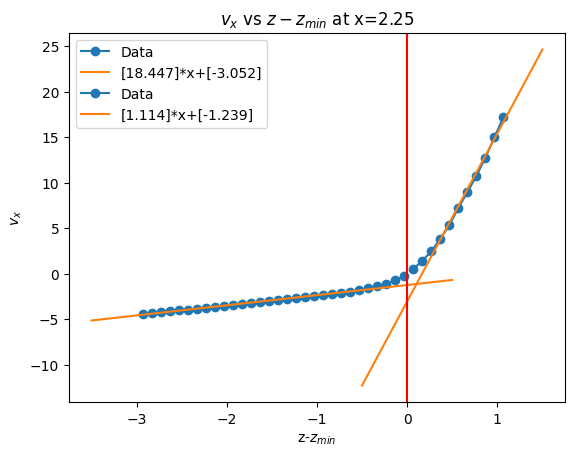

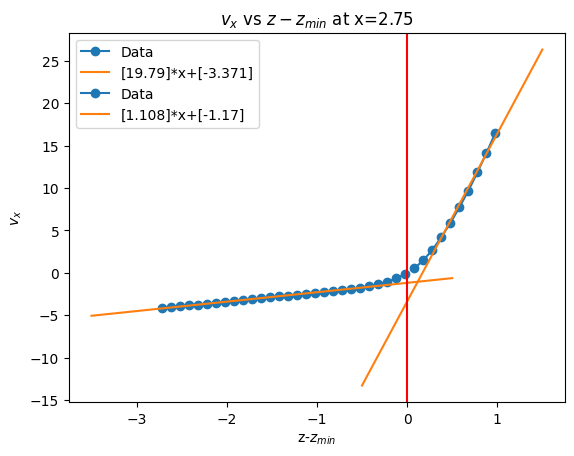

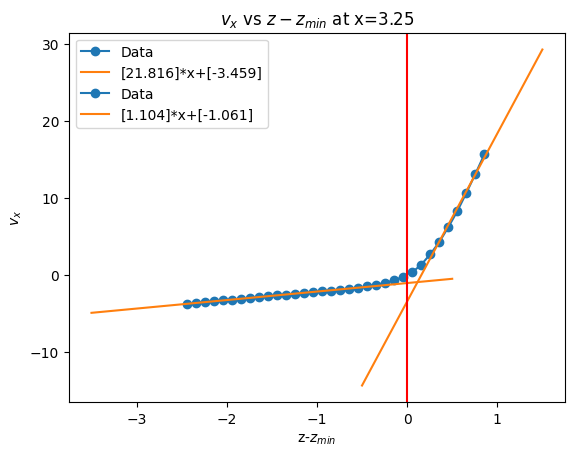

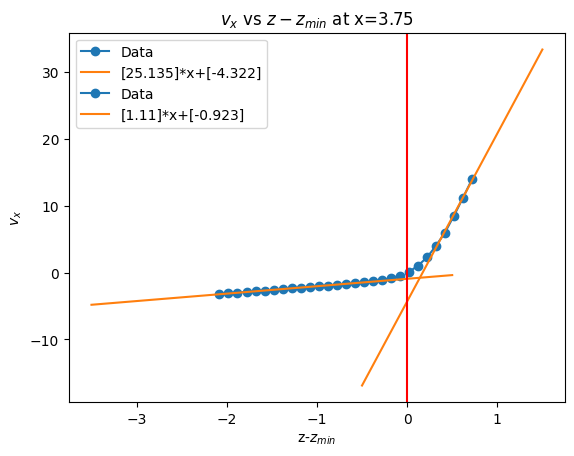

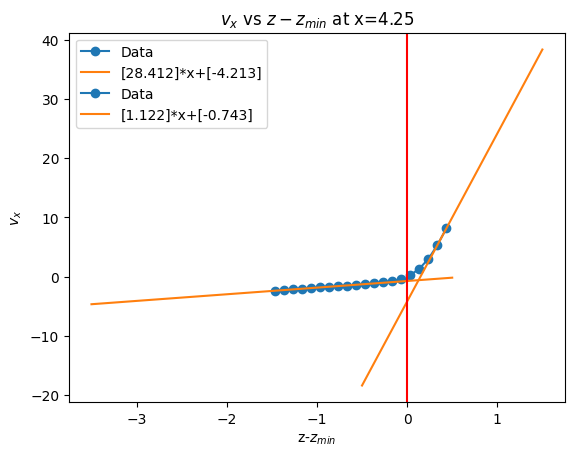

In [45]:
values_to_match = np.round(np.arange(-4.25,4.35,0.5),2)
df3 = df[df['x'].isin(values_to_match)]
df3 = df3[df3['r']<4.85]
int_points_df = pd.DataFrame(columns = ['xcoord','m1','b1','m2','b2','int_z_zmin','int_vx'])

for xcoord in values_to_match:
    df4 = df3[(df3['z']<df3['zmax']) & (df3['z']-df3['zmin']>=0)]
    df4 = df4[df4['x']==xcoord]
    df_line = df4[df4['z']-df4['zmin']>=0.25]

    if np.any(df_line) == False:
        continue
    vx = np.asarray(df_line['vx'])
    vx = vx.reshape(-1,1)
    m1,b1 = np.polyfit(df_line['z']-df_line['zmin'],vx,1)
    plt.plot(df4['z']-df4['zmin'],df4['vx'],marker='o')
    plt.plot(np.linspace(-0.5,1.5,50),m1*np.linspace(-0.5,1.5,50)+b1,c='tab:orange')
    legend = ['Data',f'{np.round(m1,3)}*x+{np.round(b1,3)}']

    plt.xlabel('z-zmin')
    plt.ylabel('vx')
    plt.title(f'vx vs z-z_min at x={xcoord}')
    ################################################################################
    df4 = df3[(df3['z']<df3['zmax']) & (df3['z']-df3['zmin']<=0)]
    df4 = df4[(df4['x']==xcoord)]
    df_line = df4[(df4['z']-df4['zmin']<=-0.25)]

    vx = np.asarray(df_line['vx'])
    vx = vx.reshape(-1,1)
    m2,b2 = np.polyfit(df_line['z']-df_line['zmin'],vx,1)
    plt.plot(df4['z']-df4['zmin'],df4['vx'],c='tab:blue',marker='o')
    plt.plot(np.linspace(-3.5,0.5,50),m2*np.linspace(-3.5,0.5,50)+b2)
    legend.append('Data')
    legend.append(f'{np.round(m2,3)}*x+{np.round(b2,3)}')

    plt.xlabel('z-$z_{min}$')
    plt.ylabel('$v_{x}$')
    plt.title(f'$v_{{x}}$ vs $z-z_{{min}}$ at x={xcoord}')
    plt.axvline(x=0,c='red')
    plt.legend(legend)
    plt.show()

    m1 = m1[0]; b1 = b1[0]; m2 = m2[0]; b2 = b2[0]
    A_matrix = [[1,-m1],[1,-m2]]
    b_matrix = [b1,b2]
    int_y,int_x = np.linalg.solve(A_matrix,b_matrix)
    int_points_df.loc[len(int_points_df)] = [xcoord,m1,b1,m2,b2,int_x, int_y]

In [46]:
for i in range(len(int_points_df)):
    for x in zmin_dict.keys():
        if int_points_df.loc[i,'xcoord'] == np.round(x,2):
            int_points_df.loc[i,'new_zmin'] = int_points_df.loc[i,'int_z_zmin']+zmin_dict[x]
            int_points_df.loc[i,'old_zmin'] = zmin_dict[x]
int_points_df

,xcoord,m1,b1,m2,b2,int_z_zmin,int_vx,new_zmin,old_zmin
0,-4.25,14.445340,-2.496615,1.382556,-0.459574,0.155942,-0.243975,-0.843123,-0.999065
1,-3.75,15.160437,-2.297597,1.304147,-0.582833,0.123753,-0.421440,-1.001619,-1.125372
2,-3.25,16.403190,-2.817161,1.287739,-0.673274,0.141834,-0.490629,-1.084188,-1.226022
3,-2.75,17.151556,-2.929672,1.292927,-0.713283,0.139759,-0.532585,-1.155476,-1.295235
4,-2.25,16.791542,-2.461655,1.275463,-0.802044,0.106961,-0.665620,-1.246936,-1.353897
5,-1.75,16.548581,-2.291546,1.253311,-0.908537,0.090421,-0.795212,-1.317656,-1.408077
6,-1.25,16.362130,-2.280102,1.238291,-0.989937,0.085307,-0.884302,-1.363245,-1.448552
7,-0.75,16.352042,-2.376836,1.205765,-1.114690,0.083330,-1.014213,-1.396485,-1.479816
8,-0.25,16.568240,-2.642628,1.183194,-1.201803,0.093651,-1.090996,-1.398937,-1.492588
9,0.25,16.836536,-2.750916,1.164842,-1.253822,0.095529,-1.142546,-1.389529,-1.485058


In [47]:
# in case of central difference approximation
def derivative_normal_int_curve(x):

    zmin = int_points_df[int_points_df['xcoord']==x] # change depending on what you want the approx to zmin to be
    for i in range(len(int_points_df)-1):
        if int_points_df.loc[i,'xcoord']==x:
            zmin = int_points_df.loc[i,'new_zmin']
            tgt = (int_points_df.loc[i+1,'new_zmin']-int_points_df.loc[i-1,'new_zmin'])/(int_points_df.loc[i+1,'xcoord']-int_points_df.loc[i-1,'xcoord'])
    normal = -1/tgt
    return [zmin,tgt,normal]

int_velocity_df = pd.DataFrame(columns = ['xcoord','zmin','vx','vz','tgt_slope','normal_slope','v_tgt','v_normal'])

for x0 in values_to_match[1:-1]:
    zmin,tgt,normal = derivative_normal_int_curve(x0)

    vx,vz = interpolate_velocity(x0,zmin)
    v_vec = np.array([vx,vz])
    normal_vec = np.array([1,normal])
    tgt_vec = np.array([1,tgt])
    v_normal = np.dot(v_vec, normal_vec)/np.linalg.norm(normal_vec)
    v_tgt = np.dot(v_vec, tgt_vec)/np.linalg.norm(tgt_vec)

    int_velocity_df.loc[len(int_velocity_df)] = [x0,zmin,vx,vz,tgt,normal,v_tgt,v_normal]

int_velocity_df['tgt_angle'] = np.arctan(int_velocity_df['tgt_slope'])*180/np.pi
int_velocity_df

,xcoord,zmin,vx,vz,tgt_slope,normal_slope,v_tgt,v_normal,tgt_angle
0,-3.75,-1.001619,0.973143,3.248295,-0.241065,4.148256,0.184799,3.385894,-13.553423
1,-3.25,-1.084188,0.555155,2.993386,-0.153858,6.499515,0.093500,3.042994,-8.746805
2,-2.75,-1.155476,0.846327,2.525210,-0.162748,6.144468,0.429700,2.628367,-9.243730
3,-2.25,-1.246936,0.767598,2.188980,-0.162179,6.166008,0.407269,2.283631,-9.211994
4,-1.75,-1.317656,0.841103,1.681291,-0.116309,8.597767,0.641231,1.767206,-6.634222
5,-1.25,-1.363245,0.542741,1.353106,-0.078829,12.685623,0.434728,1.391573,-4.507271
6,-0.75,-1.396485,0.262229,0.992753,-0.035692,28.017650,0.226651,1.001475,-2.044121
7,-0.25,-1.398937,0.245141,0.359288,0.006956,-143.756947,0.247635,-0.357574,0.398554
8,0.25,-1.389529,0.340533,-0.072177,0.037374,-26.756335,0.337600,0.084845,2.140395
9,0.75,-1.361563,0.749029,-0.699886,0.056835,-17.594644,0.708108,0.741261,3.252933


Text(0.5, 1.0, 'Normal velocity vs slope of tangent at interface')

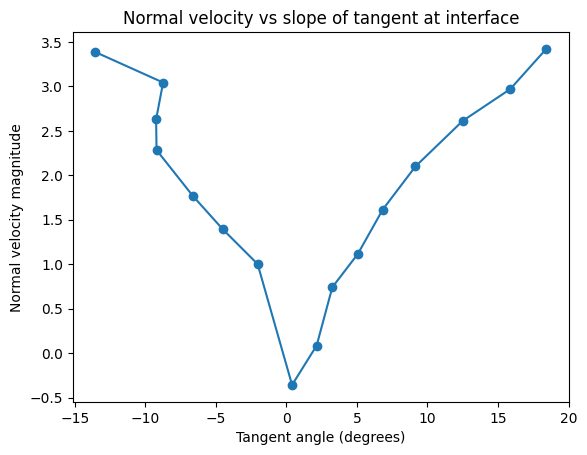

In [48]:
plt.plot(int_velocity_df['tgt_angle'],int_velocity_df['v_normal'],marker='o')
plt.xlabel('Tangent angle (degrees)')
plt.ylabel('Normal velocity magnitude')
plt.title('Normal velocity vs slope of tangent at interface')

In [49]:
print(np.asarray(int_velocity_df['tgt_angle']))
print(np.asarray(int_velocity_df['v_normal']))

[-13.55342331  -8.74680459  -9.2437302   -9.21199393  -6.63422221
  -4.50727089  -2.04412102   0.39855365   2.14039498   3.25293345
   5.05919732   6.82873772   9.14652197  12.49191484  15.86933789
  18.4206645 ]
[ 3.38589408  3.04299397  2.6283672   2.28363119  1.76720608  1.39157261
  1.00147471 -0.35757446  0.08484466  0.74126141  1.11493149  1.61489484
  2.09933129  2.61097496  2.96947178  3.42107586]
